In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, StackedWeightMatrices, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error

In [80]:
class StackedWeightMatrices:
    """
    Represents a weight matrix for a network, computing transition probabilities
    based on node and edge parameters.
    """

    def __init__(self, weight_matrix_list,
                external_dims, internal_dims, # external dims is [external_input_dim, external_output_dim], and similarly for input dims
                M_vals, A_fac, b_fac, rand_bool = True):
        """
        Initializes the weight matrix.

        Parameters:

        """
        self.weight_matrix_list = weight_matrix_list
        self.L = len(weight_matrix_list)
        self._set_input_output_inds(external_dims, internal_dims, M_vals, rand_bool)
        self._set_A_matrices(A_fac)
        self._set_b_vectors(b_fac)
        

    def _set_input_output_inds(self, external_dims, internal_dims, M_vals, rand_bool):

        ## check that lengths are correct
        assert(self.L == len(M_vals))
        assert(self.L-1 == len(internal_dims[0]))
        assert(self.L-1 == len(internal_dims[1]))

        self.external_input_inds = get_input_inds(self.weight_matrix_list[0].n_edges, external_dims[0], M_vals[0], rand_bool)
        self.external_output_inds = get_output_inds(self.weight_matrix_list[0].n_nodes, external_dims[1], rand_bool) 
        
        self.internal_input_inds = [get_input_inds(self.weight_matrix_list[l+1].n_edges, internal_dims[0][l], M_vals[l+1], rand_bool) for l in range(0, self.L-1)]
        self.internal_output_inds = [get_output_inds(self.weight_matrix_list[l].n_nodes, internal_dims[1][l], rand_bool) for l in range(0, self.L-1)]


    def _set_A_matrices(self, A_fac):

        A_matrices_list = []

        for l in range(self.L-1):
            if len(self.internal_output_inds[l]) == len(self.internal_input_inds[l]):
                A_matrices_list.append(A_fac * np.identity(len(self.internal_output_inds[l])))
            else:
                A_matrices_list.append(A_fac * np.random.rand(len(self.internal_input_inds[l]), len(self.internal_output_inds[l])))
        
        self.A_matrices_list = A_matrices_list


    def _set_b_vectors(self, b_fac):

        b_vectors_list = []

        for l in range(self.L-1):
            b_vectors_list.append(-0.5 * b_fac * np.ones(len(self.internal_input_inds[l])))
        
        self.b_vectors_list = b_vectors_list


    def compute_stacked_ss_on_inputs(self, inputs):

        ss_list = [self.weight_matrix_list[0].compute_ss_on_inputs(self.external_input_inds, inputs)]
        inputs_list = [inputs]

        for l in range(self.L-1):
            A = self.A_matrices_list[l]
            x = [ss_list[l][i] for i in self.internal_output_inds[l]]
            new_inputs = np.dot(A, x) + self.b_vectors_list[l]
            ss_list.append(self.weight_matrix_list[l+1].compute_ss_on_inputs(self.internal_input_inds[l], new_inputs))
            inputs_list.append(new_inputs)

        return ss_list, inputs_list
        

    def stacked_derivatives_of_ss(self, ss_list, inputs_list):

        full_input_inds = [(self.external_input_inds if l == 0 else self.internal_input_inds[l-1]) for l in range(self.L)]

        ## get dpi_l / dEi, dpi_l / dBij, dpi_l / dFij for each l
        dpil_dthetal_lists = [self.weight_matrix_list[l].derivatives_of_ss(full_input_inds[l], inputs_list[l]) for l in range(self.L)]

        ## get x at the internal steady states
        x_lists = [ss_list[l][np.array(self.internal_output_inds[l])]  for l in range(self.L-1)]
        
        dpil_dFIl_lists = []
        for l in range(self.L):
            n_nodes = self.weight_matrix_list[l].n_nodes
            full_inds = full_input_inds[l]
            dpil_dFIl = np.zeros((n_nodes, len(full_inds)))
            for m, inds in enumerate(full_inds):  # Iterate over columns
                dpil_dFIl[:, m] = np.sum(
                    [dpil_dthetal_lists[l][2][:, ind] for ind in inds], axis=0)
            dpil_dFIl_lists.append(dpil_dFIl)
        

        dFIl_dAl_lists = [] # L-1 of these
        dFIl_dbl_lists = [] # L-1 of these
        for l in range(1, self.L):
            dFIl_dAl = np.zeros((len(full_input_inds[l]), len(full_input_inds[l]), len(self.internal_output_inds[l-1])))
            for k in range(len(self.internal_output_inds[l-1])):
                dFIl_dAl[:,:,k] = np.identity(len(full_input_inds[l])) * x_lists[l-1][k]
            dFIl_dAl_lists.append(dFIl_dAl)
            dFIl_dbl_lists.append(np.identity(len(full_input_inds[l])))

        dpiL_dpiol_lists = [] # L-1 of these
        if self.L > 1: 
            dpiL_dpiol_lists.append(np.dot(dpil_dFIl_lists[self.L-1], self.A_matrices_list[self.L-2])) 
        for l in range(self.L-3, -1, -1):
            dpiol_dpiolm1 = np.dot(dpil_dFIl_lists[l+1][np.array(self.internal_output_inds[l+1])], self.A_matrices_list[l])
            dpiL_dpiol_lists.insert(0, np.dot(dpiL_dpiol_lists[0], dpiol_dpiolm1))

        
        dpiL_dthetal_lists = [] # L of these
        for l in range(self.L-1): # add last one outside the loop
            dpiL_dEil = np.dot(dpiL_dpiol_lists[l], dpil_dthetal_lists[l][0][np.array(self.internal_output_inds[l])])
            dpiL_dBijl = np.dot(dpiL_dpiol_lists[l], dpil_dthetal_lists[l][1][np.array(self.internal_output_inds[l])])
            dpiL_dFijl = np.dot(dpiL_dpiol_lists[l], dpil_dthetal_lists[l][2][np.array(self.internal_output_inds[l])])
            dpiL_dthetal_lists.append([dpiL_dEil, dpiL_dBijl, dpiL_dFijl])
        dpiL_dthetal_lists.append(dpil_dthetal_lists[self.L-1])


        dpiL_dAl_lists = [] # L-1 of these
        dpiL_dbl_lists = [] # L-1 of these
        for l in range(self.L-1):  
            print(l)
            if l < self.L-2:
                print("here")
                dpiL_dFIlp1 = np.dot(dpiL_dpiol_lists[l+1], dpil_dFIl_lists[l+1][np.array(self.internal_output_inds[l+1])])
            else: 
                dpiL_dFIlp1 = dpil_dFIl_lists[l+1]
            print(dpiL_dFIlp1)
            dFIlp1_dAl = np.dot(dpiL_dFIlp1, dFIl_dAl_lists[l])
            dFIlp1_dbl = np.dot(dpiL_dFIlp1, dFIl_dbl_lists[l])
            dpiL_dAl_lists.append(dFIlp1_dAl)
            dpiL_dbl_lists.append(dFIlp1_dbl)


        return dpiL_dthetal_lists, dpiL_dAl_lists, dpiL_dbl_lists

    
    def update(self, ss_list, inputs_list, class_number, eta):
        """Update the weight matrix parameters based on the error, by computing the derivatives using autodiff."""

        dpiL_dthetal_lists, dpiL_dAl_lists, dpiL_dbl_lists = self.stacked_derivatives_of_ss(ss_list, inputs_list) # get the derivatives of the steady state

        out_ind = self.external_output_inds[class_number]
        fac = 1 / (ss_list[self.L-1][out_ind])
        for l in range(self.L):
            dpiL_dthetal = dpiL_dthetal_lists[l]
            incrEj_list = fac * dpiL_dthetal[0][out_ind]
            incrBij_list = fac * dpiL_dthetal[1][out_ind]
            incrFij_list = fac * dpiL_dthetal[2][out_ind]

            self.weight_matrix_list[l].set_W_mat( # update the parameters
                self.weight_matrix_list[l].Ej_list + eta * incrEj_list, 
                self.weight_matrix_list[l].Bij_list + eta * incrBij_list, 
                self.weight_matrix_list[l].Fij_list + eta * incrFij_list)
            
        
        for l in range(self.L-1):
            incrAl = fac * dpiL_dAl_lists[l][out_ind]
            incrbl = fac * dpiL_dbl_lists[l][out_ind]

            self.A_matrices_list[l] += eta * incrAl
            self.b_vectors_list[l] += eta * incrbl

        



        

In [4]:
### Define parameters of classification
M = 2 # how many edges affected per input dimension
n_classes = 2 # D, how many classes
input_dim = 1 # D, how many components of each input data

### Define parameters of graph object and initial weights
n_nodes = 3 # assuming a complete graph


## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change

n_edges = len(list(g.edges())) 

Ej_list = [0, 1, 2]
Bij_list = [3, 4, 5]
Fij_list = [6, 7, 8]

## get input and output inds
rand_bool = False
output_inds = get_output_inds(n_nodes, n_classes, rand_bool)
input_inds = get_input_inds(n_edges, input_dim, M, rand_bool)

print(input_inds)
print(output_inds)

L = 3
external_input_dim = input_dim
external_output_dim = n_classes

# internal_input_dims = [3]
# internal_output_dims = [3]
# M_vals = [M]

internal_input_dims = [1,1]
internal_output_dims = [1,1]
M_vals = [M,M,M]


A_fac = -5
b_fac = 1

weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for l in range(L)]

external_input_inds = get_input_inds(n_edges, input_dim, M, rand_bool)


stacked_weight_matrices = StackedWeightMatrices(weight_matrix_list, 
                                                [external_input_dim, external_output_dim],
                                                [internal_input_dims, internal_output_dims],
                                                M_vals, A_fac, b_fac, rand_bool)


ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([-5.0])
dpiL_dthetal_lists, dpiL_dAl_lists, dpiL_dbl_lists = stacked_weight_matrices.stacked_derivatives_of_ss(ss_list, inputs_list)
print(ss_list)

print("dPiC / dthetaA")
print(dpiL_dthetal_lists[0][0])
print(dpiL_dthetal_lists[0][1])
print(dpiL_dthetal_lists[0][2])

print("dPiC / dthetaB")
print(dpiL_dthetal_lists[1][0])
print(dpiL_dthetal_lists[1][1])
print(dpiL_dthetal_lists[1][2])

print("dPiC / dthetaC")
print(dpiL_dthetal_lists[2][0])
print(dpiL_dthetal_lists[2][1])
print(dpiL_dthetal_lists[2][2])

print("dPiB / dA")
print(dpiL_dAl_lists)
print(dpiL_dbl_lists)


[[0, 1]]
[0, 1]
0
1
[Array([0.8590291 , 0.13908029, 0.00189061], dtype=float32), Array([0.8821464 , 0.1161247 , 0.00172885], dtype=float32), Array([0.8695356 , 0.12864472, 0.00181966], dtype=float32)]
dPiC / dthetaA
[[-3.59931686e-02  3.55104771e-02  4.82695190e-04]
 [ 3.57430871e-02 -3.52637493e-02 -4.79341411e-04]
 [ 2.50107428e-04 -2.46753326e-04 -3.35412683e-06]]
[[-5.82694842e-03  5.55365859e-03  2.73286197e-04]
 [ 5.78646262e-03 -5.51507161e-03 -2.71387397e-04]
 [ 4.04899912e-05 -3.85909693e-05 -1.89899668e-06]]
[[ 3.25944992e-02  3.53531431e-03 -1.39146732e-04]
 [-3.23680317e-02 -3.51075085e-03  1.38179936e-04]
 [-2.26490934e-04 -2.45660053e-05  9.66895455e-07]]
dPiC / dthetaB
[[ 5.92019580e-02 -5.83331666e-02 -8.68473708e-04]
 [-5.87906212e-02  5.79278661e-02  8.62439529e-04]
 [-4.11379437e-04  4.05342425e-04  6.03480420e-06]]
[[ 9.46988273e-03 -8.98443458e-03 -4.85765881e-04]
 [-9.40408572e-03  8.92201048e-03  4.82390766e-04]
 [-6.58038206e-05  6.24305642e-05  3.37546428e-06]]

In [2]:
### Define parameters of classification
M = 1 # how many edges affected per input dimension
n_classes = 2 # D, how many classes
input_dim = 1 # D, how many components of each input data

### Define parameters of graph object and initial weights
n_nodes = 3 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

### Define parameters of trainig
n_training_iters = 500 # how many training steps to take
eta = 1 # learning rate (increment of Ej, Bij, Fij)
delta_E = 1 # nuding factor (change in Ej at output nodes during nudging)


############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 

## get input and output inds
rand_bool = False
output_inds = get_output_inds(n_nodes, n_classes, rand_bool)
input_inds = get_input_inds(n_edges, input_dim, M, rand_bool)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)


############################################################
################  Load classification data #################
############################################################

######  Gaussian example
n_samples = 20000

# ### one-dimensional example
mu_1 = 10
sigma_1 = 1
dist_1 = np.random.normal(mu_1, sigma_1, n_samples)

mu_2 = -10
sigma_2 = 1
dist_2 = np.random.normal(mu_2, sigma_2, n_samples)

data_list = [[[dat] for dat in dist_1], [[dat] for dat in dist_2]]

# ## two-dimensional example
# mu_1 = -10 * np.ones(input_dim)
# cov_1 = 1.0 * np.diag(np.ones(input_dim))
# dist_1 = np.random.multivariate_normal(mu_1, cov_1, n_samples)

# mu_2 = 10 * np.ones(input_dim)
# cov_2 = 1.0 * np.diag(np.ones(input_dim))
# dist_2 = np.random.multivariate_normal(mu_2, cov_2, n_samples)

# data_list = [[dat for dat in dist_1], [dat for dat in dist_2]]


###  create InputData object
input_data = InputData(n_classes, data_list)


L = 3
external_input_dim = input_dim
external_output_dim = n_classes

internal_input_dims = [3, 3]
internal_output_dims = [3, 3]
M_vals = [M, M, M]

# L = 1
# external_input_dim = input_dim
# external_output_dim = n_classes

# internal_input_dims = []
# internal_output_dims = []
# M_vals = [M]

# L = 4
# external_input_dim = input_dim
# external_output_dim = n_classes

# internal_input_dims = [1, 2, 3]
# internal_output_dims = [4, 5, 6]
# M_vals = [M, M, M, M]

L = 2
external_input_dim = input_dim
external_output_dim = n_classes

internal_input_dims = [8]
internal_output_dims = [5]
M_vals = [M, M]

A_fac = 20
b_fac = 0

weight_matrix_list = [WeightMatrix(g, Ej_list, Bij_list, Fij_list) for l in range(L)]

external_input_inds = get_input_inds(n_edges, input_dim, M)


stacked_weight_matrices = StackedWeightMatrices(weight_matrix_list, 
                                                [external_input_dim, external_output_dim],
                                                [internal_input_dims, internal_output_dims],
                                                M_vals, A_fac, b_fac, rand_bool)





In [3]:
ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([-10])
print(np.array(stacked_weight_matrices.external_output_inds))
print(stacked_weight_matrices.b_vectors_list)
print(ss_list[-1][np.array(stacked_weight_matrices.external_output_inds)])
#print(ss_list[-2][np.array(stacked_weight_matrices.internal_output_inds)])

[0 1]
[array([-0., -0., -0., -0., -0., -0., -0., -0.])]
[9.999014e-01 4.971633e-07]


In [3]:
################################################
################  Run training #################
################################################

weight_matrix_orig = copy.deepcopy(weight_matrix) # save original rate matrix 

error_list = [] # track errors during training

n_training_iters = 250 # how many training steps to take
eta = 1

for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes) # draw a random class label to present
    inputs = next(input_data.training_data[class_number]) # get the next data point from the iterator for this class

    print(inputs)
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs(inputs)

    error_list.append(np.linalg.norm(compute_error(ss_list[-1], input_data, class_number, stacked_weight_matrices.external_output_inds))) # save error of this iteration

    stacked_weight_matrices.update(ss_list, inputs_list, class_number, eta)
    

   
    

[8.649771651586839]
[9.539053188156362]
[-9.758800783118701]
[8.797208834427629]
[8.728339896723341]
[-7.294348166471595]
[-10.257562245447417]
[9.07695338188259]
[9.705746856075294]
[10.204311257377219]
[11.719740325228297]
[8.948740121235733]
[-9.050753363948136]
[9.80466639827626]
[-8.568979384494623]
[-9.56958479389573]
[-11.386651760895358]
[9.565437471975967]
[9.866833963707498]
[8.486143371917844]
[8.258889235265691]
[-10.215177577903713]
[12.663857192630527]
[-8.899522458071015]
[10.803096673769717]
[10.26195461802435]
[11.875095670281363]
[10.766260146079365]
[-10.988441080889032]
[10.58482879935294]
[10.371463649584486]
[9.536097551655788]
[-10.01267871402973]
[10.282607415199351]
[9.291400422862075]
[10.443835375429181]
[10.823737229921017]
[10.540971179554354]
[12.220097229989722]
[8.580173717780276]
[10.31908996240194]
[9.37165797565701]
[-10.781290364129969]
[-8.979759136064636]
[-11.106715133947638]
[-10.634446239652648]
[-9.86159538117463]
[-10.110830698987439]
[9.75851

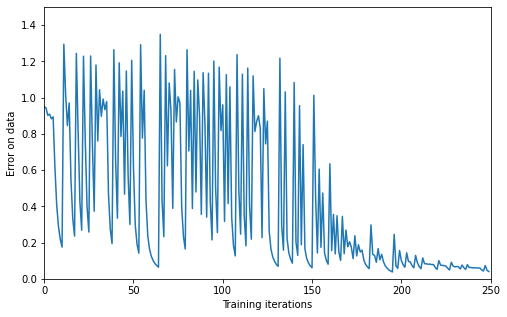

IndexError: list index out of range

In [60]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
plt.xlim(0,n_training_iters)
plt.show()


# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = np.zeros((len(x_values), len(output_inds)))


out_ind = 1
for (i, x) in enumerate(x_values):
    
    ss_list, inputs_list = stacked_weight_matrices.compute_stacked_ss_on_inputs([x])
    ss_at_outputs = [ss_list[-1][out] for out in stacked_weight_matrices.external_output_inds]
    ss_values[i,:] = ss_at_outputs  # Assuming node index 1 is of interest


# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values[:,0], label="Steady State at Node 1", color='b')
plt.plot(x_values, ss_values[:,1], label="Steady State at Node 2", color='r')

plt.hist(dist_1, density=True, color='b')
plt.hist(dist_2, density=True, color='r')

plt.xlabel("Input")
plt.ylabel("Steady State Value")
plt.ylim(0,1.)
#plt.legend()
plt.show()



In [57]:
stacked_weight_matrices.A_matrices_list

[Array([[ 1.9995386e+01, -4.4196192e-03, -7.9744169e-03],
        [ 4.1260510e-03,  2.0004108e+01,  2.2389164e-02],
        [ 1.5631167e-02,  1.4046709e-02,  2.0022772e+01]], dtype=float32),
 Array([[19.86663   , -0.11609805, -0.27625734],
        [-0.18067127, 19.843267  , -0.43722352],
        [-0.25573188, -0.22933728, 19.520466  ]], dtype=float32)]

In [28]:
stacked_weight_matrices.b_vectors_list

[Array([-0.0235416 ,  0.06740638, -0.39308408], dtype=float32),
 Array([ 0.7976702, -9.0069275,  8.172239 ], dtype=float32)]